In [9]:
import math

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning

In [7]:
df_grid_meps = pd.read_csv("../experiments/grid/meps.csv")
df_random_meps = pd.read_csv("../experiments/random/meps.csv")

In [10]:
# Transformations described in the paper in order to make the output domain [-inf, inf] for modelling with GPs
# and turn the optimisation process into maximisation across all objectives (required by BoTorch)
def process_fairness_value(val):
    return math.log(1 - val) - math.log(val)

def revert_fairness_value(val):
    return 1 / (1 + math.e**(val))

def process_privacy_value(val):
    return - math.log(val)

def revert_privacy_value(val):
    return math.e**(-val)

def process_accuracy_value(val):
    return math.log(val) - math.log(1 - val)

def revert_accuracy_value(val):
    return 1 / (1 + math.e**(-val))

In [11]:
anti_ideal_point = torch.FloatTensor([
    process_accuracy_value(0.0001),
    process_fairness_value(1 - 0.0001),
    process_privacy_value(1)
    ])

In [15]:
y_grid_meps = torch.FloatTensor([
    df_grid_meps["Classification error"],
    df_grid_meps["Fairness after"],
    df_grid_meps["Privacy budget"]
]).T

In [21]:
df_grid_meps.shape[0]

256

In [16]:
y_grid_meps.shape

torch.Size([256, 3])

In [17]:
bd = DominatedPartitioning(ref_point = anti_ideal_point, Y = y_grid_meps)
volume = bd.compute_hypervolume().item()

In [34]:
def get_volumes(df):
    volumes = []
    for i in range(df.shape[0]):
        y = torch.FloatTensor([
            df["Classification error"][:i],
            df["Fairness after"][:i],
            df["Privacy budget"][:i]
        ]).T

        bd = DominatedPartitioning(ref_point = anti_ideal_point, Y = y)
        volume = bd.compute_hypervolume().item()
        volumes.append(volume)
    return volumes

In [35]:
volumes_grid_meps = get_volumes(df_grid_meps)
volumes_random_meps = get_volumes(df_random_meps)

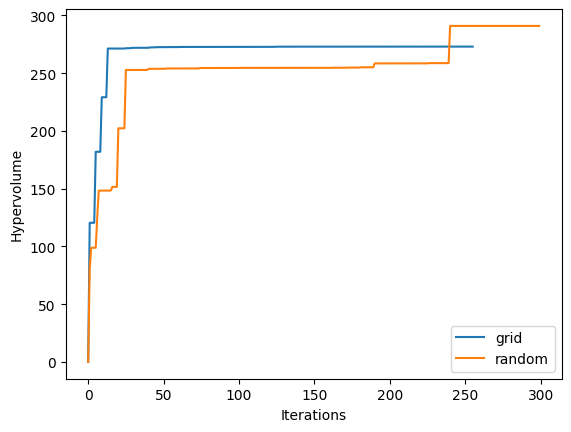

In [39]:
plt.plot(range(len(volumes_grid_meps)), volumes_grid_meps, label="grid")
plt.plot(range(len(volumes_random_meps)), volumes_random_meps, label="random")
plt.xlabel("Iterations")
plt.ylabel("Hypervolume")
plt.legend()